# Addestramento e Valutazione di RetinaNet per il Rilevamento di Segnali Stradali

Questo notebook implementa una pipeline per l'addestramento e la valutazione del modello **RetinaNet**.

---


 # Impostazione dell'Ambiente:
 * Installazione e importazione delle librerie necessarie, principalmente PyTorch e Detectron2 con le sue dipendenze.

In [1]:
!pip install torch
!pip install torchvision

In [4]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -U .
!pip wheel .
%cd ..

fatal: destination path 'detectron2' already exists and is not an empty directory.
/kaggle/working/detectron2/detectron2
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
/kaggle/working/detectron2


* Importazione delle librerie richieste

In [5]:
import os
import torch
import detectron2
from detectron2 import *
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, hooks
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,DatasetMapper 
from tqdm import tqdm
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds

import detectron2.utils.comm as comm
import time
import datetime

import logging
import numpy as np

In [6]:
workdir = "RetinaNetV1"

---

# Preparazione del Dataset:

* Download e preparazione del dataset personalizzato di segnali stradali da Roboflow, in formato COCO.
* Registrazione dei set di training, validazione e test con Detectron2 (`register_coco_instances`) per renderli accessibili al framework.
* Visualizzazione di alcune immagini e annotazioni del dataset per verifica.

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3TtQzlTxV5vuuUIr5sJk")
project = rf.workspace("toquinho").project("object-detection-signals")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.6 MB/s eta 0:00:0000:0100:01
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Object-Detection-Signals-1 in coco:: 100%|██████████| 1599/1599 [00:00<00:00, 5971.92it/s]


In [8]:
nome_del_dataset = "Object-Detection-Signals-1"

In [9]:

register_coco_instances("my_dataset_train", {}, nome_del_dataset + "/train/_annotations.coco.json", nome_del_dataset + "/train")
register_coco_instances("my_dataset_val", {}, nome_del_dataset + "/valid/_annotations.coco.json", nome_del_dataset + "/valid")
register_coco_instances("my_dataset_test", {}, nome_del_dataset + "/test/_annotations.coco.json", nome_del_dataset + "/test")


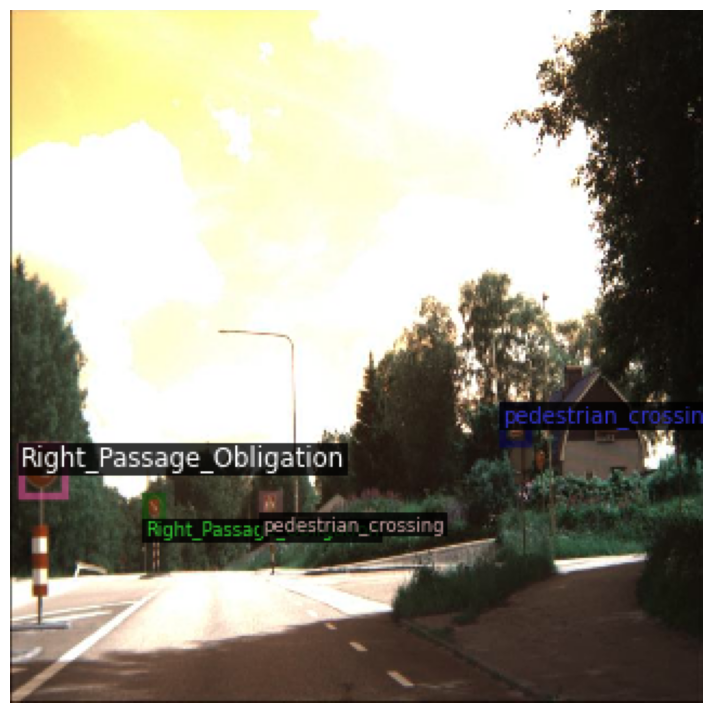

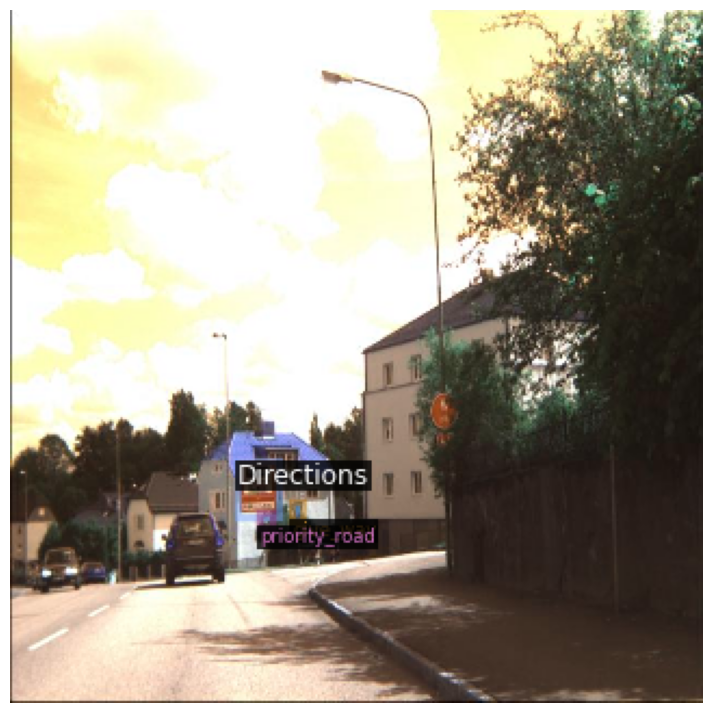

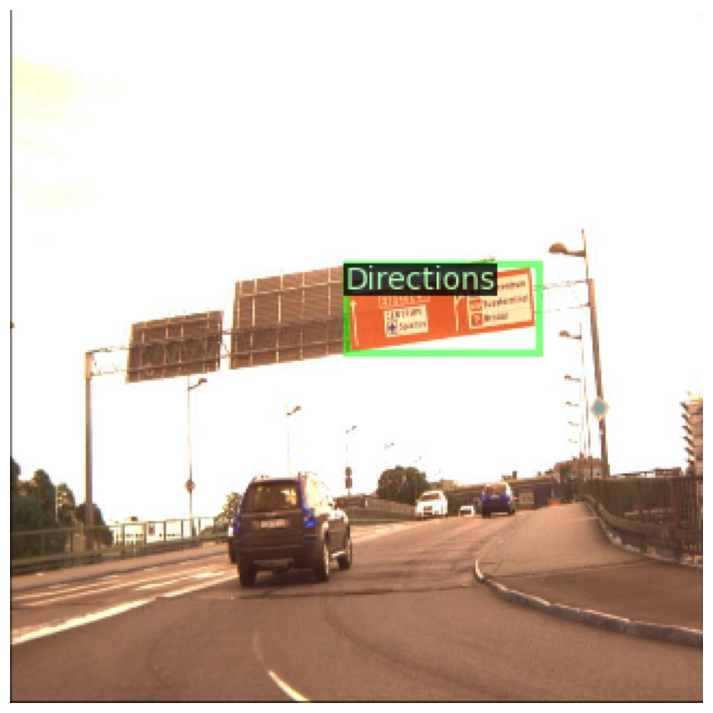

In [10]:
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    plt.figure(figsize=(12, 9))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

## Struttura Dataset

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("my_dataset_train")
metadata = MetadataCatalog.get("my_dataset_train")

class_counts = {class_name: 0 for class_name in metadata.thing_classes}

for d in dataset_dicts:
    for ann in d['annotations']:
        class_id = ann['category_id']
        class_name = metadata.thing_classes[class_id]
        class_counts[class_name] += 1

for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} elementi")

Classe 'Signals': 0 elementi
Classe 'Directions': 447 elementi
Classe 'Do_not_stop': 117 elementi
Classe 'Right_Passage_Obligation': 170 elementi
Classe 'deviation': 43 elementi
Classe 'give_way': 181 elementi
Classe 'parking_area': 57 elementi
Classe 'pedestrian_crossing': 321 elementi
Classe 'priority_road': 156 elementi
Classe 'prohibition': 40 elementi
Classe 'speed_limits': 272 elementi
Classe 'stop': 13 elementi
Classe 'work_in_progress': 20 elementi


---

# TRANING RETINANET

### Avvio dell'Addestramento del Modello RetinaNet

In questa sezione, viene configurato e avviato l'addestramento del modello di object detection **RetinaNet**.

**Configurazione Principale:**
* **Durata Addestramento**:
    * Epoche totali: **60 epoche**.
    * Iterazioni totali: **4140** (calcolate come 60 epoche * 69 iterazioni/epoca).
* **Batch Size per Solver**: **16** immagini per batch.
* **Learning Rate Iniziale**: **0.001**.
* **Iterazioni di Warmup**: **500** iterazioni.

**Checkpointing e Valutazione:**
* **Salvataggio Checkpoint**: Un checkpoint del modello verrà salvato ogni **20 epoche** (ogni 1380 iterazioni).
* **Valutazione Periodica**: Le prestazioni del modello sul set di validazione (`"my_dataset_val"`) verranno calcolate ogni **epoca** (ogni 69 iterazioni) utilizzando `COCOEvaluator`.

### funzione per calcolare e registrare periodicamente le diverse componenti della Loss

In [12]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        
        
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
        
        start_time = time.perf_counter()
        total_compute_time = 0
        
        classification_losses = []
        regression_losses = []
        rpn_cls_losses = []
        rpn_bbox_losses = []
        total_losses = []
        
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            
            cls_loss_batch, reg_loss_batch, rpn_cls_loss_batch, rpn_bbox_loss_batch = self._get_loss(inputs)
            classification_losses.append(cls_loss_batch)
            regression_losses.append(reg_loss_batch)
            rpn_cls_losses.append(rpn_cls_loss_batch)
            rpn_bbox_losses.append(rpn_bbox_loss_batch)
            
            total_loss_batch = cls_loss_batch + reg_loss_batch + rpn_cls_loss_batch + rpn_bbox_loss_batch
            total_losses.append(total_loss_batch)

        mean_cls_loss = np.mean(classification_losses)
        mean_reg_loss = np.mean(regression_losses)
        mean_rpn_cls_loss = np.mean(rpn_cls_losses)
        mean_rpn_bbox_loss = np.mean(rpn_bbox_losses)
        mean_total_loss = np.mean(total_losses)

        self.trainer.storage.put_scalar('validation_total_loss', mean_total_loss)
        self.trainer.storage.put_scalar('validation_classification_loss', mean_cls_loss)
        self.trainer.storage.put_scalar('validation_regression_loss', mean_reg_loss)
        self.trainer.storage.put_scalar('validation_rpn_cls_loss', mean_rpn_cls_loss)
        self.trainer.storage.put_scalar('validation_rpn_bbox_loss', mean_rpn_bbox_loss)

        comm.synchronize()
        return classification_losses, regression_losses, rpn_cls_losses, rpn_bbox_losses
            
    def _get_loss(self, data):
        metrics_dict = self._model(data)

        cls_loss = metrics_dict.get('loss_cls', 0)
        reg_loss = metrics_dict.get('loss_box_reg', 0)
        rpn_cls_loss = metrics_dict.get('loss_rpn_cls', 0)
        rpn_bbox_loss = metrics_dict.get('loss_rpn_bbox', 0)

        cls_loss = cls_loss.detach().cpu().item() if isinstance(cls_loss, torch.Tensor) else float(cls_loss)
        reg_loss = reg_loss.detach().cpu().item() if isinstance(reg_loss, torch.Tensor) else float(reg_loss)
        rpn_cls_loss = rpn_cls_loss.detach().cpu().item() if isinstance(rpn_cls_loss, torch.Tensor) else float(rpn_cls_loss)
        rpn_bbox_loss = rpn_bbox_loss.detach().cpu().item() if isinstance(rpn_bbox_loss, torch.Tensor) else float(rpn_bbox_loss)

        return cls_loss, reg_loss, rpn_cls_loss, rpn_bbox_loss
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()

        self.trainer.storage.put_scalars(timetest=12)

## funzione per la progress bar

In [13]:
class TQDMHook(hooks.HookBase):
    def __init__(self, max_iter, eval_period):
        self.pbar = tqdm(total=max_iter, desc="Training Progress")
        self.eval_period = eval_period

    def after_step(self):
        self.pbar.update(1)
        metrics = self.trainer.storage.latest()

        total_loss = metrics.get("total_loss", 0)
        lr = metrics.get("lr", 0)

        postfix = {
            'train_loss': total_loss,
            'lr': lr
        }

        self.pbar.set_postfix(postfix)

        next_iter = self.trainer.iter + 1
        if next_iter % self.eval_period == 0 or next_iter == self.trainer.max_iter:
            self._update_validation_losses()

    def _update_validation_losses(self):
        metrics = self.trainer.storage.latest()

        validation_total_loss = metrics.get("validation_total_loss", None)
        validation_cls_loss = metrics.get("validation_classification_loss", None)
        validation_reg_loss = metrics.get("validation_regression_loss", None)
        validation_rpn_cls_loss = metrics.get("validation_rpn_cls_loss", None)
        validation_rpn_bbox_loss = metrics.get("validation_rpn_bbox_loss", None)

        postfix = {}

        if validation_total_loss is not None:
            postfix['val_total_loss'] = validation_total_loss
        if validation_cls_loss is not None:
            postfix['val_cls_loss'] = validation_cls_loss
        if validation_reg_loss is not None:
            postfix['val_reg_loss'] = validation_reg_loss
        if validation_rpn_cls_loss is not None:
            postfix['val_rpn_cls_loss'] = validation_rpn_cls_loss
        if validation_rpn_bbox_loss is not None:
            postfix['val_rpn_bbox_loss'] = validation_rpn_bbox_loss

        if postfix:
            self.pbar.set_postfix(postfix)

    def after_train(self):
        self.pbar.close()

### Definizione del Trainer Personalizzato 

In [14]:

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs(cfg.OUTPUT_DIR + "/inference", exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
class MyTrainerWithGradAccumulation(MyTrainer):
    def __init__(self, cfg, grad_accumulation_steps=2):
        super().__init__(cfg)
        self.grad_accumulation_steps = grad_accumulation_steps
        self._data_loader_iter = iter(self.data_loader) 

    def run_step(self):
        """
        Perform a single training iteration with gradient accumulation.
        """
        assert self.model.training, "[MyTrainerWithGradAccumulation] Model was changed to eval mode!"

        if not hasattr(self, "_data_loader_iter"):
            self._data_loader_iter = iter(self.data_loader)
        start = time.perf_counter()
        data = next(self._data_loader_iter)
        data_time = time.perf_counter() - start

        with torch.autograd.set_detect_anomaly(True):
            loss_dict = self.model(data)
            losses = sum(loss_dict.values())

            losses = losses / self.grad_accumulation_steps
            losses.backward()  

            if (self.iter + 1) % self.grad_accumulation_steps == 0:
                self.optimizer.step()  
                self.optimizer.zero_grad()  

        self.storage.put_scalars(**loss_dict, smoothing_hint=False)


In [16]:
from torch.optim.lr_scheduler import LambdaLR

class MyTrainerWithGradAccumulationAndLinearLR(MyTrainerWithGradAccumulation):
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        def linear_lr_lambda(current_step):
            warmup_iters = cfg.SOLVER.WARMUP_ITERS
            warmup_factor = cfg.SOLVER.WARMUP_FACTOR 

            if current_step < warmup_iters:
                return warmup_factor + (1 - warmup_factor) * (current_step / warmup_iters)
  
            total_decay_iters = cfg.SOLVER.MAX_ITER - warmup_iters
            return max(0, 1 - (current_step - warmup_iters) / total_decay_iters)

        return LambdaLR(optimizer, lr_lambda=linear_lr_lambda)


## Configurazione del modello

In [17]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 16 
cfg.SOLVER.MAX_ITER = 4140   #train/batch*epoche
cfg.SOLVER.CHECKPOINT_PERIOD = 1380
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_FACTOR = 0.001
cfg.TEST.EVAL_PERIOD = 69 #numelementi/batchsize
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.RETINANET.NUM_CLASSES = 13
cfg.OUTPUT_DIR = workdir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


---

## avvio training

In [ ]:

grad_accumulation_steps = 1  
trainer =  MyTrainer(cfg)
trainer.register_hooks([TQDMHook(cfg.SOLVER.MAX_ITER, cfg.TEST.EVAL_PERIOD)])
trainer.resume_or_load(resume=False)
trainer.train()


---

In [ ]:
import torch
import cv2
import glob
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

model = trainer.model
model.eval() 

co = 0

for img in glob.glob(nome_del_dataset + '/test/*.jpg') [:10]:
    if co == 20:
        break

    inputs = cv2.imread(img)
    
    inputs_tensor = torch.as_tensor(inputs.astype("float32").transpose(2, 0, 1))
    inputs_tensor = [{"image": inputs_tensor}] 

    # Eseguo l'inferenza
    with torch.no_grad(): 
        outputs = model(inputs_tensor)

    co += 1

    metadata_test = MetadataCatalog.get("my_dataset_test")
    
    # Visualizza i risultati
    v = Visualizer(inputs[:, :, ::-1], metadata=metadata_test, scale=1.2)
    out = v.draw_instance_predictions(outputs[0]['instances'].to('cpu'))

    # Visualizza l'immagine usando matplotlib
    plt.figure(figsize=(6, 8))
    plt.imshow(out.get_image()[:, :, ::-1]) 
    plt.axis('off')
    plt.show()


---

### Valutazione dei checkpoint con diverse soglie NMS e confidenza

In questa sezione vengono valutati tre modelli RetinaNet precedentemente addestrati, corrispondenti ai checkpoint `model_0001379.pth`, `model_0002759.pth` e `model_0004149.pth`.

Per ciascun modello, viene eseguita l’inferenza sul validation set variando:
- la soglia di **Non-Maximum Suppression (NMS)**;
- la soglia di **confidenza minima** per accettare una predizione.

L’obiettivo è identificare la combinazione di soglie che **ottimizza le prestazioni** in termini di **mAP (mean Average Precision)** calcolata sulla classe `bbox`.

Alla fine, per ogni modello, vengono riportate le soglie ottimali e la mAP corrispondente.


In [18]:

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [20]:
import numpy as np
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

score_thresholds = np.arange(0.3, 0.5, 0.1) 
nms_thresholds = [0.2,0.3]

model_checkpoints = [ "/kaggle/working/RetinaNetV1/model_0001379.pth","/kaggle/working/RetinaNetV1/model_0002759.pth","/kaggle/working/RetinaNetV1/model_0004139.pth","/kaggle/working/RetinaNetV1/model_final.pth"]
best_nms = None
best_score = None
best_metric = -1


# Per ogni modello
for checkpoint in model_checkpoints:
    best_nms = None
    best_score = None
    best_metric = -1 
    
    print(f"\nValutando modello: {checkpoint}")
    
    # Itera sui diversi valori di soglia per NMS
    for nms_thresh in nms_thresholds:
        for score_thresh in score_thresholds:
            
            cfg = get_cfg()
            cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
            
            cfg.DATASETS.TRAIN = ("my_dataset_train",)
            cfg.DATASETS.TEST = ("my_dataset_val",)
            cfg.OUTPUT_DIR = workdir
            cfg.MODEL.RETINANET.NUM_CLASSES = 13
            cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, checkpoint)

            # Aggiorna le soglie di NMS 
            cfg.MODEL.RETINANET.NMS_THRESH_TEST = nms_thresh # Soglia NMS per i risultati finali
            cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3 
           
            trainer = MyTrainer(cfg)
            trainer.resume_or_load(resume=False)
        
            val_loader = build_detection_test_loader(cfg, "my_dataset_val")
            evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir=f"./output_val_{checkpoint}/")
           
            results = inference_on_dataset(trainer.model, val_loader, evaluator)
            
            metric = results["bbox"]["AP"]  
            
            print(f"Modello: {checkpoint}, NMS: {nms_thresh}, Confidenza: {score_thresh}, mAP: {metric}")
            
            if metric > best_metric:
                best_metric = metric
                best_nms = nms_thresh
                best_score = score_thresh

    print(f"Migliore NMS per {checkpoint}: {best_nms}, Migliore Confidenza: {best_score}, mAP: {best_metric}")



Valutando modello: /kaggle/working/RetinaNetV1/model_0001379.pth


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

---

### Valutazione finale del modello con i pesi ottimali

In questa cella viene effettuata la **valutazione finale** del modello RetinaNet addestrato, utilizzando i pesi salvati in `model_final.pth`.  
L’inferenza viene eseguita sul dataset di test (`my_dataset_test`), utilizzando soglie fisse per:

- **NMS (Non-Maximum Suppression)** = 0.1
- **Confidenza minima di classificazione** = 0.3

I risultati ottenuti, valutati tramite `COCOEvaluator`, includono metriche standard come **AP, AP50, AP75**, e sono stampati in output.  
Il salvataggio dei risultati avviene nella cartella `output_test_FINAL/`.


In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.OUTPUT_DIR = workdir
cfg.MODEL.RETINANET.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/RetinaNetV1/model_final.pth")

cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.1
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3 

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

val_loader = build_detection_test_loader(cfg, "my_dataset_test")
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir=f"./output_test_FINAL/")

results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.

---


## visualizzazione predizioni

[{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[286.2472, 310.2057, 357.9787, 343.0163],
        [285.8132, 343.7574, 358.8984, 368.4807],
        [196.2545, 322.6007, 285.6206, 375.6221]], device='cuda:0')), scores: tensor([0.9925, 0.9873, 0.9803], device='cuda:0'), pred_classes: tensor([1, 1, 1], device='cuda:0')])}]


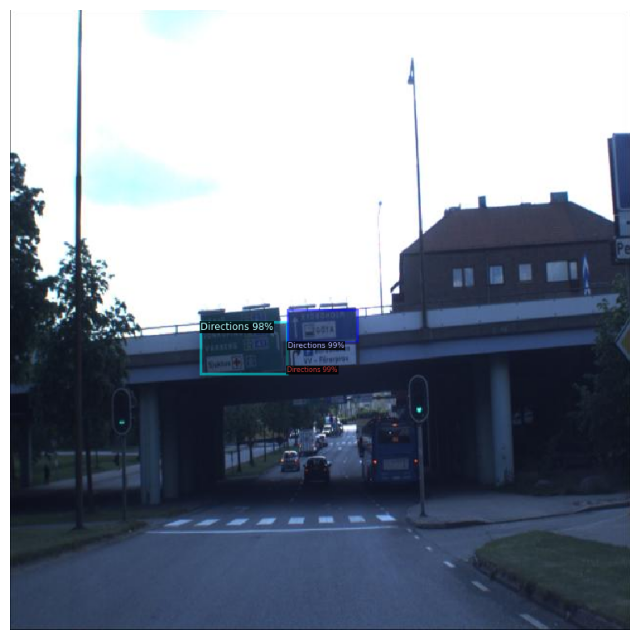

[{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[377.4746, 287.0112, 450.6616, 401.9319]], device='cuda:0')), scores: tensor([0.3451], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}]


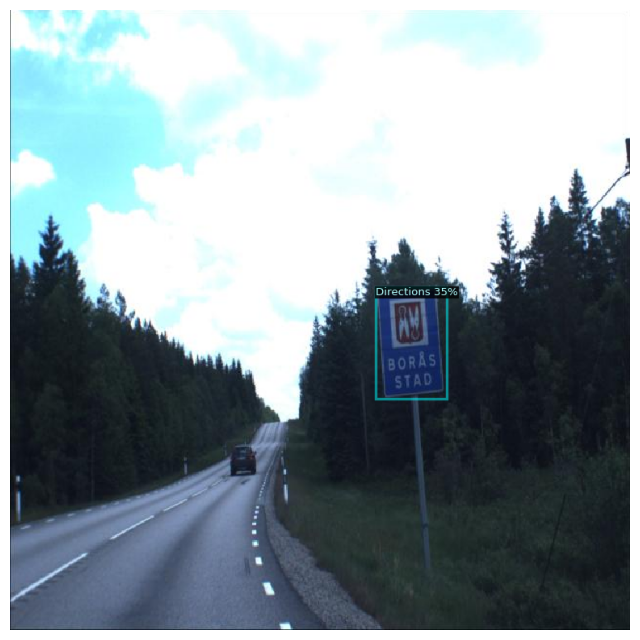

[{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}]


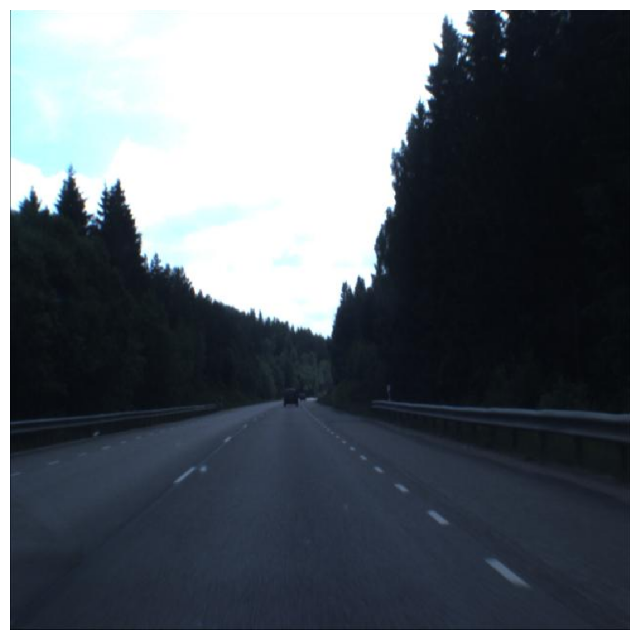

[{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[242.4567, 414.7201, 295.4612, 468.0651],
        [ 20.6806, 466.4564,  30.2955, 478.7119],
        [ 87.7259, 463.0130,  96.8667, 474.6893]], device='cuda:0')), scores: tensor([0.9846, 0.6875, 0.4562], device='cuda:0'), pred_classes: tensor([1, 3, 8], device='cuda:0')])}]


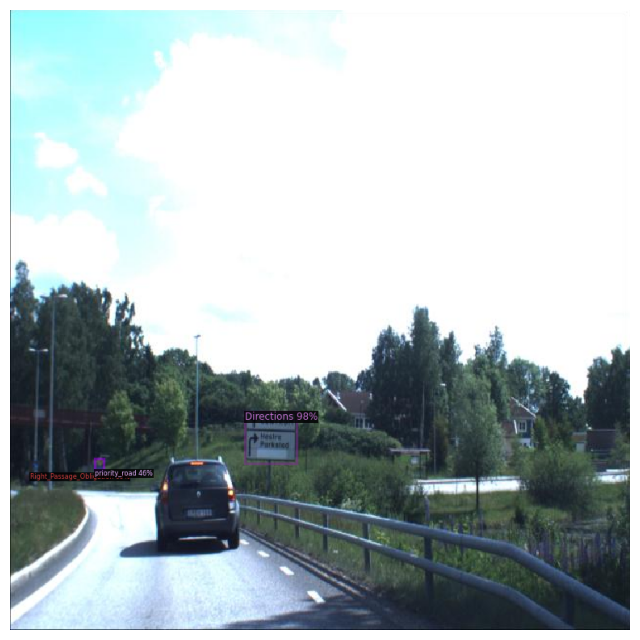

[{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}]


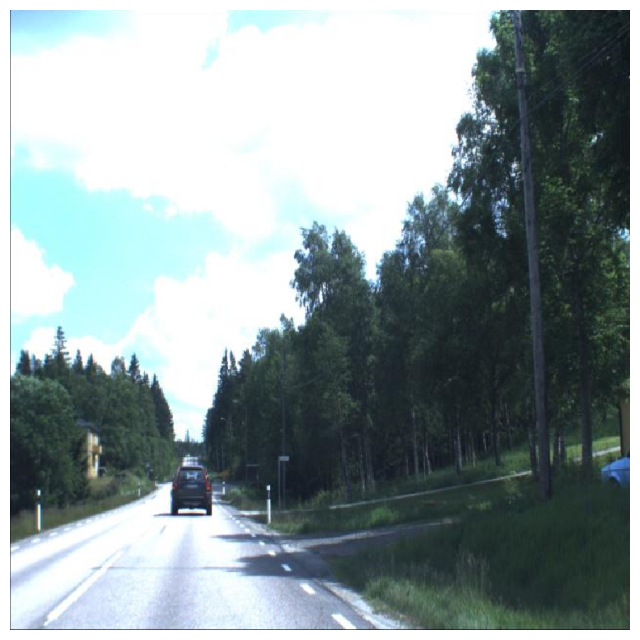

[{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[273.5607, 349.6178, 300.6124, 382.7332],
        [  6.9566, 355.2137,  31.9977, 388.6744],
        [  7.0207, 386.5008,  31.7387, 421.7694],
        [537.1065, 232.0539, 639.8925, 415.0301]], device='cuda:0')), scores: tensor([0.9933, 0.9656, 0.9581, 0.9073], device='cuda:0'), pred_classes: tensor([5, 7, 3, 1], device='cuda:0')])}]


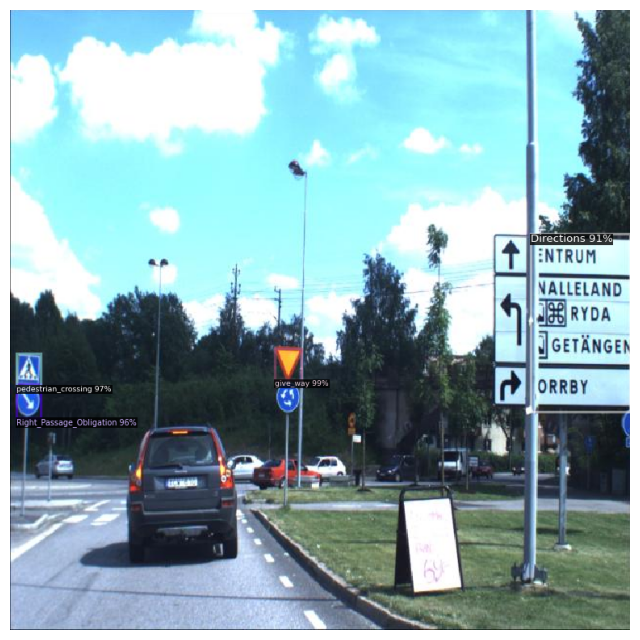

[{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[342.5573, 325.8410, 386.6819, 383.6588]], device='cuda:0')), scores: tensor([0.9991], device='cuda:0'), pred_classes: tensor([2], device='cuda:0')])}]


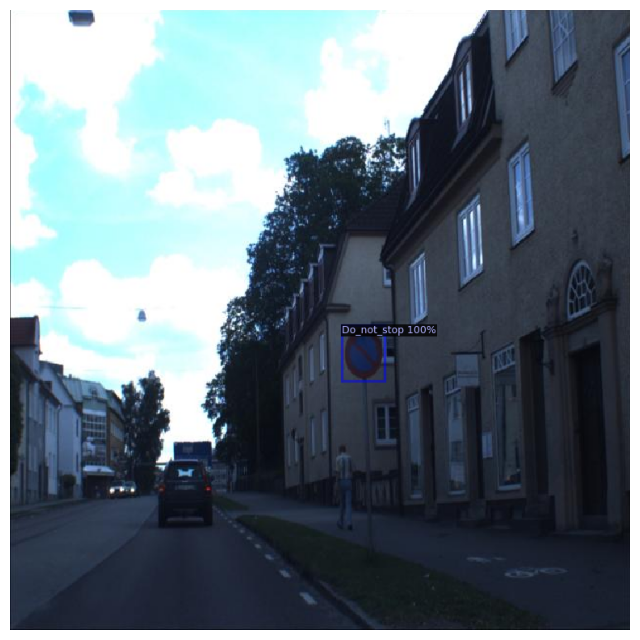

[{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[331.0966, 449.1114, 350.3856, 474.4977]], device='cuda:0')), scores: tensor([0.5875], device='cuda:0'), pred_classes: tensor([8], device='cuda:0')])}]


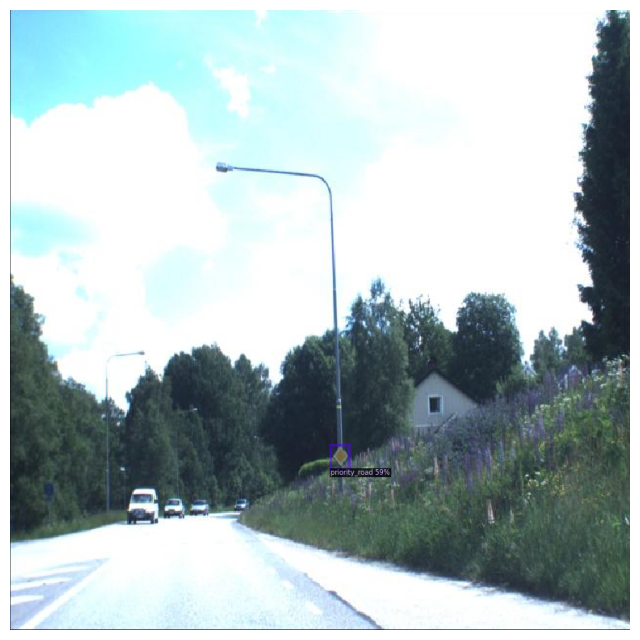

In [28]:
import torch
import cv2
import glob
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

model = trainer.model
model.eval()  
co = 0

for img in glob.glob(nome_del_dataset + '/test/*.jpg'):
    if co == 8:
        break

    inputs = cv2.imread(img)
    inputs_tensor = torch.as_tensor(inputs.astype("float32").transpose(2, 0, 1)) 
    inputs_tensor = [{"image": inputs_tensor}]

    # Eseguo inferenza
    with torch.no_grad(): 
        outputs = model(inputs_tensor)

    print(outputs)
    co += 1  
    
    metadata_test = MetadataCatalog.get("my_dataset_test")
    
    # Visualizza i risultati
    v = Visualizer(inputs[:, :, ::-1], metadata=metadata_test, scale=1.2)
    out = v.draw_instance_predictions(outputs[0]['instances'].to('cpu'))
    # Visualizza l'immagine usando matplotlib
    plt.figure(figsize=(8,12))
    plt.imshow(out.get_image()[:, :, ::])  # Converti da BGR a RGB per plt.imshow
    plt.axis('off')
    plt.show()


---

# Download

In [3]:
import shutil
from IPython.display import HTML


def zip_folder(folder_path, output_path):
    shutil.make_archive(output_path, 'zip', folder_path)

def create_download_link(zip_file_name):
    return HTML('<a href="{}" target="_blank" download>Click here to download {}</a>'.format(zip_file_name, zip_file_name))

folder_to_zip = workdir 
zip_file_name = workdir  

zip_folder(folder_to_zip, zip_file_name)

create_download_link(zip_file_name + '.zip')
